     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=76e0db1c3e0a3628302d261fc2ba2790f437439c547486896ec138e8ddb7c1ff
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.


One-Class SVM Results
[[85  5]
 [ 0 10]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        90
         1.0       0.67      1.00      0.80        10

    accuracy                           0.95       100
   macro avg       0.83      0.97      0.89       100
weighted avg       0.97      0.95      0.95       100


Isolation Forest Results
[[90  0]
 [ 0 10]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        90
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


PCA Results
[[90  0]
 [ 0 10]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        90
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro 

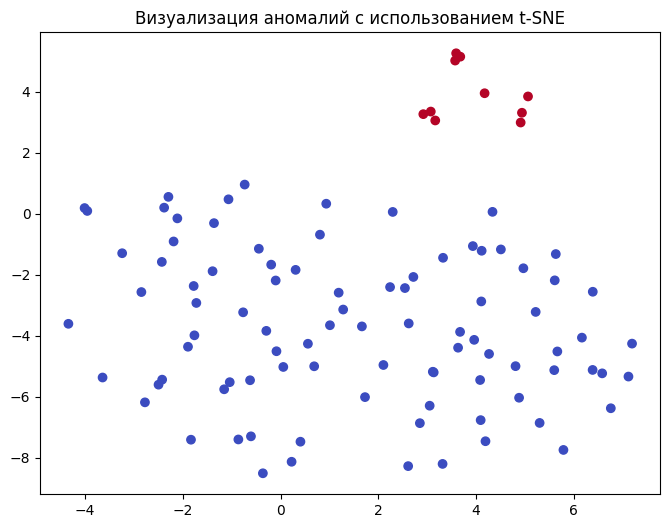

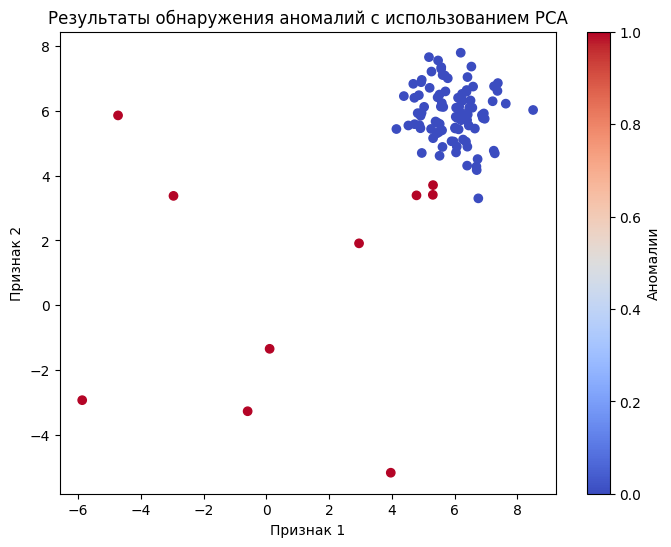

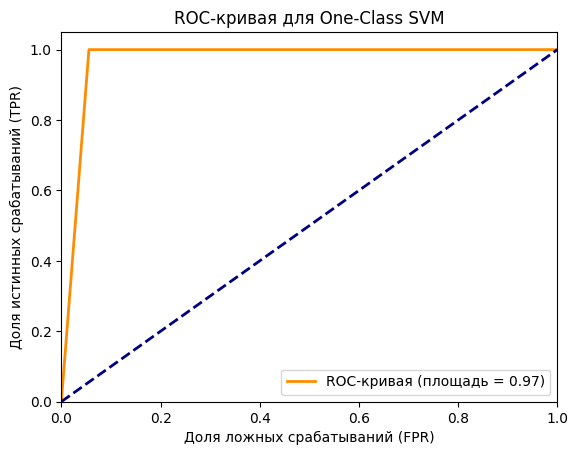

In [2]:
!pip install pyod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from pyod.models.pca import PCA as PCA_OD
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.utils.data import generate_data

# Генерация данных
X_train, X_test, y_train, y_test = generate_data(n_train=200, n_test=100, n_features=5, contamination=0.1, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. One-Class SVM с оптимизацией гиперпараметров
ocsvm = OCSVM(kernel='rbf')
param_grid_svm = {'nu': [0.01, 0.05, 0.1], 'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(ocsvm, param_grid_svm, cv=3, scoring='neg_mean_squared_error')  # Изменено на метрику, не требующую y_true
grid_svm.fit(X_train_scaled)
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

# 2. Isolation Forest с оптимизацией гиперпараметров
isoforest = IForest()
param_grid_iforest = {'n_estimators': [50, 100, 150], 'max_samples': ['auto', 0.8], 'contamination': [0.1, 0.15]}
grid_iforest = GridSearchCV(isoforest, param_grid_iforest, cv=3, scoring='neg_mean_squared_error')  # Изменено на метрику, не требующую y_true
grid_iforest.fit(X_train_scaled)
best_iforest = grid_iforest.best_estimator_
y_pred_iforest = best_iforest.predict(X_test_scaled)

# 3. PCA для поиска аномалий
pca_model = PCA_OD(contamination=0.1)
pca_model.fit(X_train_scaled)
y_pred_pca = pca_model.predict(X_test_scaled)

# Оценка результатов
def print_results(y_test, y_pred, method_name):
    print(f"\n{method_name} Results")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

print_results(y_test, y_pred_svm, "One-Class SVM")
print_results(y_test, y_pred_iforest, "Isolation Forest")
print_results(y_test, y_pred_pca, "PCA")

# 4. Визуализация данных с использованием t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_iforest, cmap='coolwarm')
plt.title("Визуализация аномалий с использованием t-SNE")
plt.show()

# 5. Визуализация результатов PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_pca, cmap='coolwarm')
plt.title("Результаты обнаружения аномалий с использованием PCA")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.colorbar(label='Аномалии')
plt.show()

# 6. ROC-кривая для One-Class SVM
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (площадь = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложных срабатываний (FPR)')
plt.ylabel('Доля истинных срабатываний (TPR)')
plt.title('ROC-кривая для One-Class SVM')
plt.legend(loc="lower right")
plt.show()
